# Homework 1

**Name**: Dyson Lewis

**UID**: 106033522


## Preparation (download data and import packages)

In [1]:
# Download a processed version of the data
!wget https://huggingface.co/hk/hw1/resolve/main/mushroom.txt

--2025-10-20 22:28:12--  https://huggingface.co/hk/hw1/resolve/main/mushroom.txt
Resolving huggingface.co (huggingface.co)... 2600:9000:24ba:a600:17:b174:6d00:93a1, 2600:9000:24ba:ce00:17:b174:6d00:93a1, 2600:9000:24ba:f200:17:b174:6d00:93a1, ...
Connecting to huggingface.co (huggingface.co)|2600:9000:24ba:a600:17:b174:6d00:93a1|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: /api/resolve-cache/models/hk/hw1/d23e2ca56c2eb67af93a318c77348b936dcf4d12/mushroom.txt?%2Fhk%2Fhw1%2Fresolve%2Fmain%2Fmushroom.txt=&etag=%2212401d069edc9c3b8be14236a657b917ab324a19%22 [following]
--2025-10-20 22:28:12--  https://huggingface.co/api/resolve-cache/models/hk/hw1/d23e2ca56c2eb67af93a318c77348b936dcf4d12/mushroom.txt?%2Fhk%2Fhw1%2Fresolve%2Fmain%2Fmushroom.txt=&etag=%2212401d069edc9c3b8be14236a657b917ab324a19%22
Reusing existing connection to [huggingface.co]:443.
HTTP request sent, awaiting response... 200 OK
Length: 1264848 (1.2M) [text/plain]
Saving to: ‘mu

In [2]:
# Use only the provided packages
import sys
import math
import csv
import pandas
import os
import random
import numpy as np
from collections import Counter
from dataclasses import dataclass

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score

mpl.lines.width = 2
mpl.axes.labelsize = 14

# 3.1 Visualizing Features

In [3]:
# Load the Mushroom dataset

@dataclass
class Dataset:
    """Class for the dataset."""
    X: np.array
    y: np.array
    Xnames: list
    yname: str

def load_data(data_file='mushroom.txt'):
    """Load data and map strings to numbers."""
    data = pandas.read_csv(data_file).to_numpy()
    n = data.shape[0]
    d = data.shape[1] - 1
    # Map strings to numbers
    X = np.zeros((n, d))
    for i in range(d):
        mapping = {name: j for j, name in enumerate(sorted(set(data[:, i+1])))}
        for j in range(n):
            X[j, i] = mapping[data[j, i+1]]
    mapping = {'POISONOUS': 0, 'EDIBLE': 1}
    y = np.zeros(n, dtype=np.int32)
    for j in range(n):
        y[j] = mapping[data[j, 0]]
    #0 'cap-shape',
    #1 'cap-surface',
    #2 'cap-color',
    #3 'bruises',
    #4 'odor',
    #5 'gill-attachment',
    #6 'gill-spacing',
    #7 'gill-size',
    #8 'gill-color',
    #9 'stalk-shape',
    #10 'stalk-root',
    #11 'stalk-surface-above-ring',
    #12 'stalk-surface-below-ring',
    #13 'stalk-color-above-ring',
    #14 'stalk-color-below-ring',
    #15 'veil-type',
    #16 'veil-color',
    #17 'ring-number',
    #18 'ring-type',
    #19 'spore-print-color',
    #20 'population',
    #21 'habitat',
    Xnames = [
        'cap-shape',
        'cap-surface',
        'cap-color',
        'bruises',
        'odor',
        'gill-attachment',
        'gill-spacing',
        'gill-size',
        'gill-color',
        'stalk-shape',
        'stalk-root',
        'stalk-surface-above-ring',
        'stalk-surface-below-ring',
        'stalk-color-above-ring',
        'stalk-color-below-ring',
        'veil-type',
        'veil-color',
        'ring-number',
        'ring-type',
        'spore-print-color',
        'population',
        'habitat',
    ]
    # We only use these 6 features
    features = [0, 3, 4, 9, 11, 16]
    X = np.take(X, features, axis=-1)
    Xnames = [Xnames[i] for i in features]
    print(f"Features selected: {Xnames}")
    return Dataset(X=X, y=y, Xnames=Xnames, yname='edible')

data = load_data()

X = data.X; Xnames = data.Xnames
y = data.y; yname = data.yname
n,d = X.shape  # n = number of examples, d =  number of features


# Shuffle the data for cross-validation
import random
idx = list(range(n))
random.seed(0)
random.shuffle(idx)
X = np.take(X, idx, axis=0)
y = np.take(y, idx, axis=0)

Features selected: ['cap-shape', 'bruises', 'odor', 'stalk-shape', 'stalk-surface-above-ring', 'veil-color']


In [4]:
def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,20))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend()

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values.    # aka n rows and d columns-- so n instances and d features per instance
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

    return data, bins, align, labels

<Figure size 640x480 with 0 Axes>

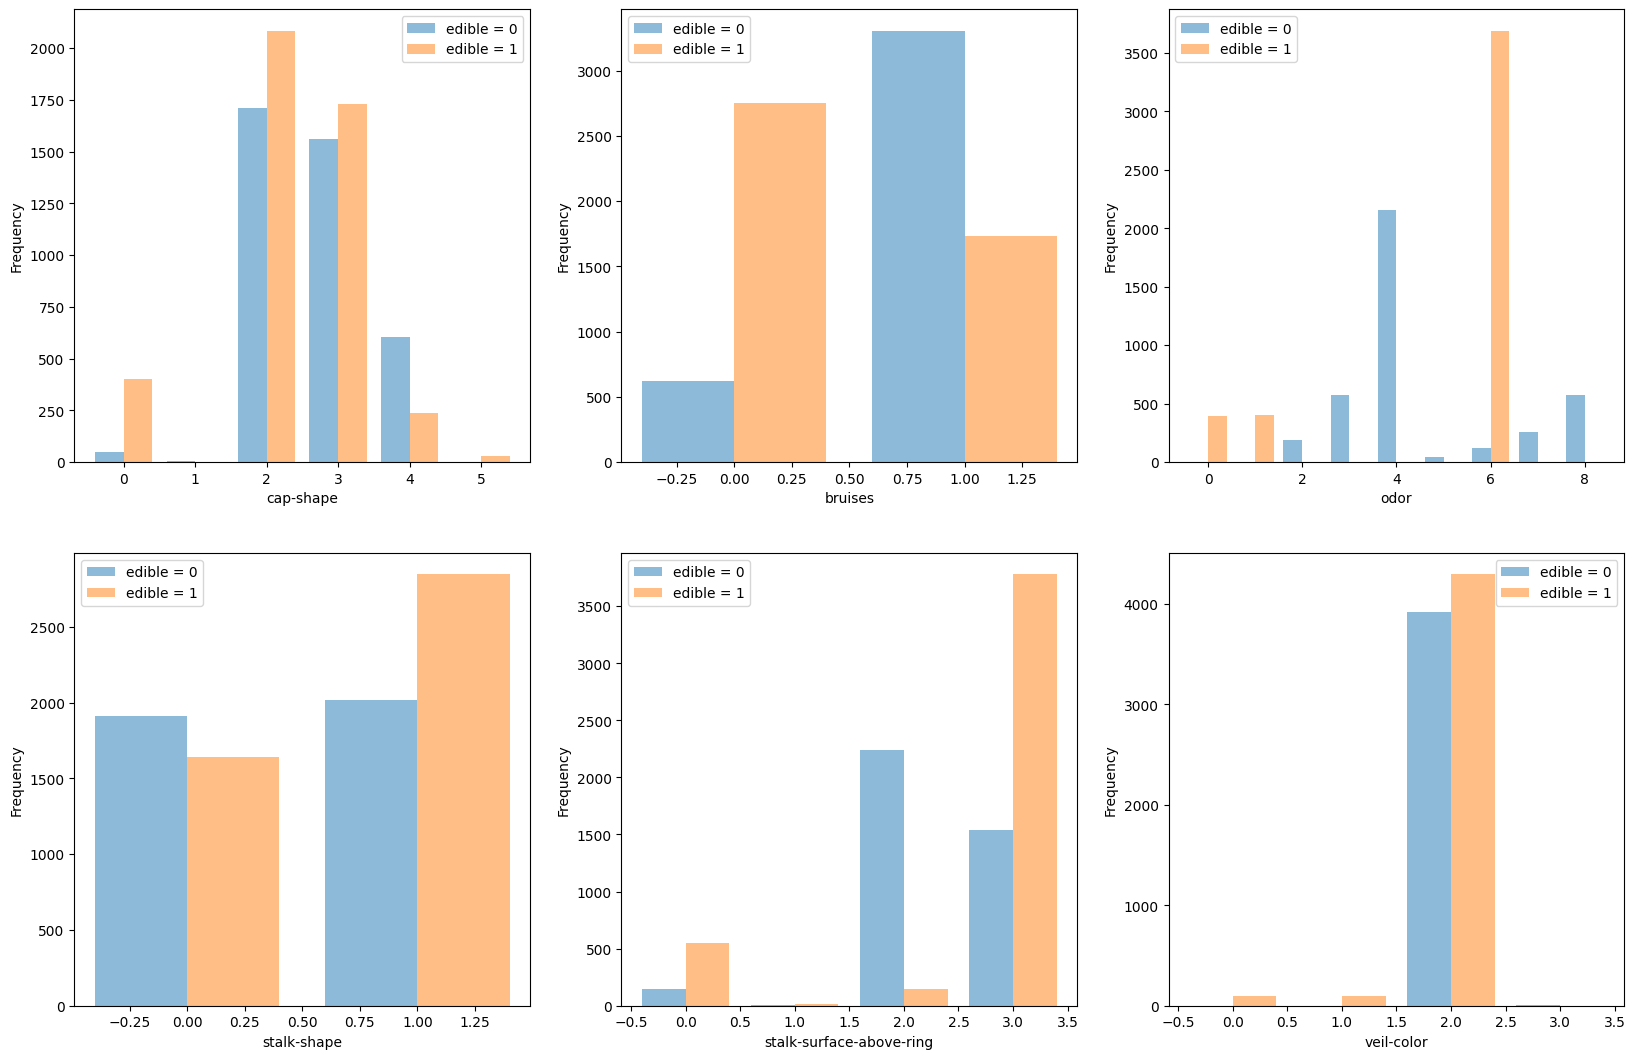

In [5]:
plt.figure()

plot_histograms (X, y, Xnames=Xnames, yname=yname)

# 3.2 Training and Evaluating Models

## Majority Vote Classifier

In [6]:
class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        # most_common(n) returns an array of the n most commmon values, where the values themselves are a (key, value_count) tuple
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n # makes an n element array, where every element is self.prediction
        return y

In [7]:
# train Majority Vote classifier on data
print('Classifying using Majority Vote...')
clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
y_pred = clf.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)

Classifying using Majority Vote...
	-- training error: 0.467


## (a) Implement Random Classifier and Evaluate

In [8]:
class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """


        ### ========== TODO (a): START ========== ###
        # set self.probabilities_ according to the training set
        classes, counts = np.unique(y, return_counts = True)
        probs = counts / counts.sum()
        self.probabilities_ = dict(zip(classes, probs))
        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        n, d = X.shape

        ### ========== TODO (a): START ========== ###
        # predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)
        if self.probabilities_ is None:
            raise Exception("Classifier not initialized")
        np.random.seed(seed)

        n, d = X.shape
        classes = list(self.probabilities_.keys())
        probs = list(self.probabilities_.values())

        y_pred = np.random.choice(classes, size = n, p = probs)
        return y_pred
        ### ========== TODO : END ========== ###

In [9]:
def problem_a_solution():
    """
    Initialize a RandomClassifier and evaluate its training error on X and y.

    Returns
    --------------------
        error    -- float, training error of the RandomClassifier, between 0 and 1
    """
    ### ========== TODO (a): START ========== ###
    # evaluate training error of Random classifier
    clf = RandomClassifier()
    clf.fit(X, y)
    y_pred = clf.predict(X)

    # training error = fraction of misclassified samples
    error = np.mean(y_pred != y)
    return error
    ### ========== TODO : END ========== ###

In [10]:
# ==============================================================================
#  LOCKED CELL: DO NOT EDIT
# ------------------------------------------------------------------------------
# This cell is for grading purposes. Any changes will be overwritten.
# ==============================================================================

print(f'PROBLEM_A_ANSWER: {problem_a_solution()}')

PROBLEM_A_ANSWER: 0.5032679738562091


## (b) Evaluate Decision Tree Classifier

In [11]:
def problem_b_solution():
    """
    Initialize a DecisionTreeClassifier and evaluate its training error on X and y.

    Returns
    --------------------
        error    -- float, training error of the classifier, between 0 and 1
    """
    ### ========== TODO (b): START ========== ###
    # evaluate training error of Decision Tree classifier
    # create the classifier with entropy criterion
    clf = DecisionTreeClassifier(criterion='entropy', random_state=0)
    
    # train the classifier
    clf.fit(X, y)
    
    # predict on the training set
    y_pred = clf.predict(X)
    
    # compute training error
    error = np.mean(y_pred != y)
    return error
    ### ========== TODO : END ========== ###

In [12]:
# ==============================================================================
#  LOCKED CELL: DO NOT EDIT
# ------------------------------------------------------------------------------
# This cell is for grading purposes.
# ==============================================================================

print(f'PROBLEM_B_RESPONSE: {problem_b_solution()}')

PROBLEM_B_RESPONSE: 0.0076054664289958405


## (c) Evaluate KNN Classifier

In [13]:
def problem_c_solution():
    """
    Initialize a KNeighborsClassifier and evaluate its training error on X and y.

    Returns
    --------------------
        error_1    -- float, training error of the classifier when k=3, between 0 and 1
        error_2    -- float, training error of the classifier when k=7, between 0 and 1
        error_3    -- float, training error of the classifier when k=21, between 0 and 1

    """
    ### ========== TODO (c): START ========== ###
    # evaluate training error of k-Nearest Neighbors classifier
    # use k = 3, 7, 21 for n_neighbors
    # k = 3
    knn3 = KNeighborsClassifier(n_neighbors=3)
    knn3.fit(X, y)
    y_pred3 = knn3.predict(X)
    error_1 = np.mean(y_pred3 != y)

    # k = 7
    knn7 = KNeighborsClassifier(n_neighbors=7)
    knn7.fit(X, y)
    y_pred7 = knn7.predict(X)
    error_2 = np.mean(y_pred7 != y)

    # k = 21
    knn21 = KNeighborsClassifier(n_neighbors=21)
    knn21.fit(X, y)
    y_pred21 = knn21.predict(X)
    error_3 = np.mean(y_pred21 != y)

    return error_1, error_2, error_3
    ### ========== TODO : END ========== ###

In [14]:
# ==============================================================================
#  LOCKED CELL: DO NOT EDIT
# ------------------------------------------------------------------------------
# This cell is for grading purposes.
# ==============================================================================

error_1, error_2, error_3 = problem_c_solution()

print(f'PROBLEM_C_RESPONSE_1: {error_1}')
print(f'PROBLEM_C_RESPONSE_2: {error_2}')
print(f'PROBLEM_C_RESPONSE_3: {error_3}')

PROBLEM_C_RESPONSE_1: 0.012596553773024361
PROBLEM_C_RESPONSE_2: 0.013309566250742722
PROBLEM_C_RESPONSE_3: 0.008793820558526441


## (d) Define the `error()` Function and Evaluate

In [15]:
def error(clf, X, y, ntrials=1, test_size=0.0):
    """
    Returns (train_error, test_error, f1_micro_avg) averaged over ntrials.
    If test_size==0.0, returns the training error only (traing error averaged).
    """
    train_errors = []
    test_errors = []
    f1_scores = []

    if test_size <= 0.0:
        # Only training error: train on full X and compute error on the same
        clf.fit(X, y)
        y_pred = clf.predict(X)
        train_err = np.mean(y_pred != y)  # fraction incorrect
        return train_err, 0.0, f1_score(y, y_pred, average='micro')

    sss = StratifiedShuffleSplit(n_splits=ntrials, test_size=test_size, random_state=0)
    for train_idx, test_idx in sss.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf.fit(X_train, y_train)
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)

        train_err = np.mean(y_train_pred != y_train)
        test_err = np.mean(y_test_pred != y_test)
        f1_micro = f1_score(y_test, y_test_pred, average='micro')

        train_errors.append(train_err)
        test_errors.append(test_err)
        f1_scores.append(f1_micro)

    return np.mean(train_errors), np.mean(test_errors), np.mean(f1_scores)

In [16]:
def problem_d_solution():
    """
    Incur the error() function on the four classifiers, and report their f1 scores.
    Use 'ntrials=100' and 'test_size=0.10'.

    Returns
    --------------------
        f1_score_1    -- float, f1 score of MajorityVoteClassifier, between 0 and 1
        f1_score_2    -- float, f1 score of RandomClassifier, between 0 and 1
        f1_score_3    -- float, f1 score of DecisionTreeClassifier (use criterion='entropy'), between 0 and 1
        f1_score_4    -- float, f1 score of KNeighborsClassifier (use 'n_neighbors=7'), between 0 and 1
    """
    ### ========== TODO (d): START ========== ###
    # use cross-validation to compute average training and test error of classifiers
    ntrials = 100
    test_size = 0.10

    # 1. Majority Vote Classifier
    clf1 = MajorityVoteClassifier()      # assumes this class is defined elsewhere
    _, _, f1_score_1 = error(clf1, X, y, ntrials=ntrials, test_size=test_size)

    # 2. Random Classifier
    clf2 = RandomClassifier()
    _, _, f1_score_2 = error(clf2, X, y, ntrials=ntrials, test_size=test_size)

    # 3. Decision Tree (entropy)
    clf3 = DecisionTreeClassifier(criterion='entropy', random_state=0)
    _, _, f1_score_3 = error(clf3, X, y, ntrials=ntrials, test_size=test_size)

    # 4. k-Nearest Neighbors (k=7)
    clf4 = KNeighborsClassifier(n_neighbors=7)
    _, _, f1_score_4 = error(clf4, X, y, ntrials=ntrials, test_size=test_size)

    return f1_score_1, f1_score_2, f1_score_3, f1_score_4
    ### ========== TODO : END ========== ###

In [17]:
# ==============================================================================
#  LOCKED CELL: DO NOT EDIT
# ------------------------------------------------------------------------------
# This cell is for grading purposes.
# ==============================================================================

f1_score_1, f1_score_2, f1_score_3, f1_score_4 = problem_d_solution()

print(f'PROBLEM_D_RESPONSE_1: {f1_score_1}')
print(f'PROBLEM_D_RESPONSE_2: {f1_score_2}')
print(f'PROBLEM_D_RESPONSE_3: {f1_score_3}')
print(f'PROBLEM_D_RESPONSE_4: {f1_score_4}')

PROBLEM_D_RESPONSE_1: 0.533254156769596
PROBLEM_D_RESPONSE_2: 0.505581947743468
PROBLEM_D_RESPONSE_3: 0.9926484560570071
PROBLEM_D_RESPONSE_4: 0.9910570071258907


## (e) Find the Best Value of K

In [18]:
def problem_e_solution():
    """
    Use 5-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier,
    and the corresponding f1 score.

    Returns
    --------------------
        best_k      -- integer, best value of k
        f1_score    -- float, f1 score of KNeighborsClassifier, between 0 and 1
    """
    k_values = list(range(1, 51, 2))  # odd k values from 1 to 50
    scores = []
    for k in k_values:
        clf = KNeighborsClassifier(n_neighbors=k)
        cv_scores = cross_val_score(clf, X, y, cv=5, scoring='f1_micro')
        scores.append(np.mean(cv_scores))

    best_index = int(np.argmax(scores))
    best_k = k_values[best_index]
    best_score = scores[best_index]

    return best_k, best_score

In [19]:
# ==============================================================================
#  LOCKED CELL: DO NOT EDIT
# ------------------------------------------------------------------------------
# This cell is for grading purposes.
# ==============================================================================

best_k, f1_score = problem_e_solution()

print(f'PROBLEM_E_RESPONSE_1: {best_k}')
print(f'PROBLEM_E_RESPONSE_2: {f1_score}')

PROBLEM_E_RESPONSE_1: 33
PROBLEM_E_RESPONSE_2: 0.9913250148544266


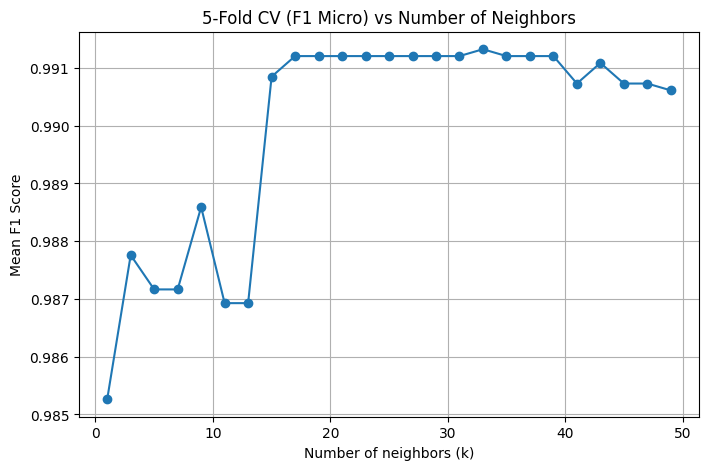

In [20]:
# ===== TODO (e) plot: START =====
k_values = list(range(1, 51, 2))
scores = []

for k in k_values:
    clf = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(clf, X, y, cv=5, scoring='f1_micro')
    scores.append(np.mean(cv_scores))

plt.figure(figsize=(8, 5))
plt.plot(k_values, scores, marker='o')
plt.title('5-Fold CV (F1 Micro) vs Number of Neighbors')
plt.xlabel('Number of neighbors (k)')
plt.ylabel('Mean F1 Score')
plt.grid(True)
plt.show()
# ===== TODO (e) plot: END =====

## (f) Find the Best Depth

In [21]:
def problem_f_solution():
    """
    Use 20-fold cross-validation to find the best depth for DecisionTreeClassifier,
    and the corresponding F1 score.

    Returns
    --------------------
        best_depth -- integer, best depth value
        f1_score   -- float, best cross-validated F1 score, between 0 and 1
    """
    depths = list(range(1, 21))  # depth limits from 1 to 20
    mean_train_scores = []
    mean_test_scores = []

    for depth in depths:
        clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=0)
        cv_results = cross_validate(clf, X, y, cv=20, scoring='f1_micro', return_train_score=True)
        mean_train_scores.append(np.mean(cv_results['train_score']))
        mean_test_scores.append(np.mean(cv_results['test_score']))

    # best depth = smallest depth that gives maximum test score
    max_test_score = max(mean_test_scores)
    best_depth_idx = mean_test_scores.index(max_test_score)
    best_depth = depths[best_depth_idx]
    best_f1 = max_test_score

    return best_depth, best_f1  # only these two for grading

In [22]:
# ==============================================================================
#  LOCKED CELL: DO NOT EDIT
# ------------------------------------------------------------------------------
# This cell is for grading purposes.
# ==============================================================================

best_depth, f1_score = problem_f_solution()

print(f'PROBLEM_F_RESPONSE_1: {best_depth}')
print(f'PROBLEM_F_RESPONSE_2: {f1_score}')

PROBLEM_F_RESPONSE_1: 9
PROBLEM_F_RESPONSE_2: 0.992393394412397


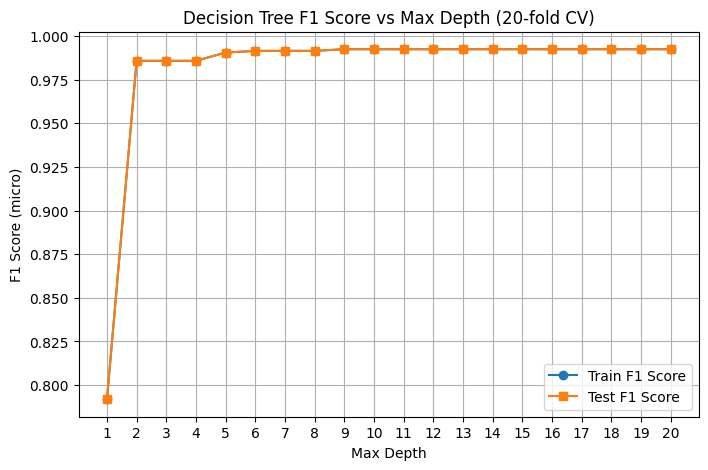

In [23]:
# ===== TODO (f) plot: START =====
depths = list(range(1, 21))
mean_train_scores = []
mean_test_scores = []

for depth in depths:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=0)
    cv_results = cross_validate(clf, X, y, cv=20, scoring='f1_micro', return_train_score=True)
    mean_train_scores.append(np.mean(cv_results['train_score']))
    mean_test_scores.append(np.mean(cv_results['test_score']))

plt.figure(figsize=(8, 5))
plt.plot(depths, mean_train_scores, marker='o', label='Train F1 Score')
plt.plot(depths, mean_test_scores, marker='s', label='Test F1 Score')
plt.title('Decision Tree F1 Score vs Max Depth (20-fold CV)')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score (micro)')
plt.xticks(depths)
plt.grid(True)
plt.legend()
plt.show()
# ===== TODO (f) plot: END =====

## (g) Utilize the Decision Tree

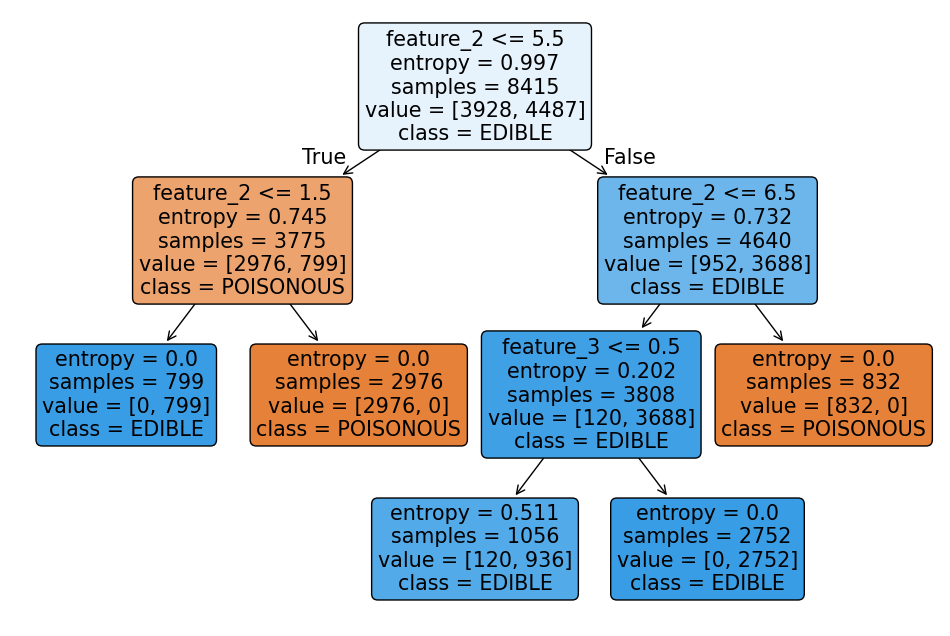

In [24]:
plt.figure(figsize=(12, 8))
### ===== TODO (g) plot: START ===== ###
# Fit the DecisionTreeClassifier with max_depth=3, criterion='entropy'
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
clf.fit(X, y)

plot_tree(
    clf,
    feature_names=[f'feature_{i}' for i in range(X.shape[1])],
    class_names=['POISONOUS', 'EDIBLE'],
    filled=True,
    rounded=True
)
plt.show()
### ========== TODO : END ========== ###

In [25]:
def problem_g_solution():
    """
    Determine if the given example x=[0,1,6,0,0,0] is edible.
    Returns True if edible, False otherwise.
    """
    x = np.array([[0, 1, 6, 0, 0, 0]])
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
    clf.fit(X, y)
    prediction = clf.predict(x)[0]
    edible = (prediction == 1)   # 1 = EDIBLE, 0 = POISONOUS
    return edible

In [26]:
# ==============================================================================
#  LOCKED CELL: DO NOT EDIT
# ------------------------------------------------------------------------------
# This cell is for grading purposes.
# ==============================================================================

edible = problem_g_solution()
print(f'PROBLEM_G_RESPONSE: {edible}')

PROBLEM_G_RESPONSE: True
